# Basic Statistical Analysis

## Objective
To apply statistical rigor to the findings from the EDA phase. We aim to validate:
1.  **Correlation**: Relationship between Enrolment and Updates.
2.  **Seasonality Significance**: Is the "March Peak" statistically significant?
3.  **Outlier Detection**: Statistically identify high-volume districts using Z-Scores.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
plt.style.use('ggplot')

# Load Data
df = pd.read_csv("../data/processed/master_data.csv")
df['date'] = pd.to_datetime(df['date'])
print(f"Data Loaded. Shape: {df.shape}")

Data Loaded. Shape: (2965393, 14)


## Correlation Analysis
We examine if there is a linear relationship between **New Enrolments** and **Updates**. A high correlation might suggest that regions with population growth (enrolment) also drive administrative changes (updates).

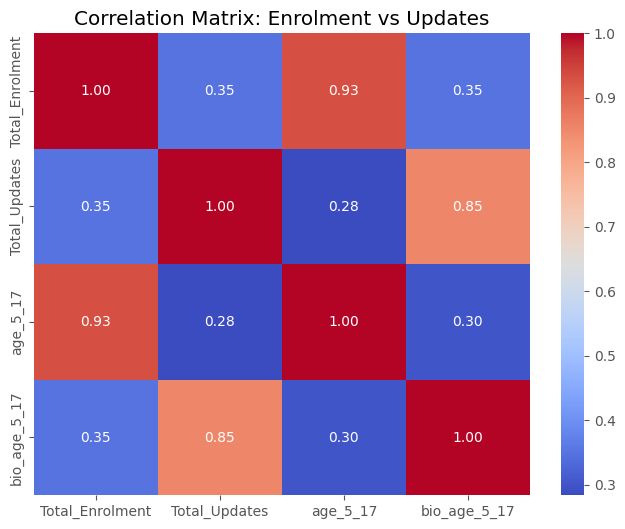

Correlation Coefficients:
                  Total_Enrolment  Total_Updates  age_5_17  bio_age_5_17
Total_Enrolment         1.000000       0.350656  0.931706      0.348384
Total_Updates           0.350656       1.000000  0.283663      0.853606
age_5_17                0.931706       0.283663  1.000000      0.298378
bio_age_5_17            0.348384       0.853606  0.298378      1.000000


In [3]:
corr_matrix = df[['Total_Enrolment', 'Total_Updates', 'age_5_17', 'bio_age_5_17']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix: Enrolment vs Updates')
plt.show()

print("Correlation Coefficients:\n", corr_matrix)

## Hypothesis Testing: The "March Effect"
**Null Hypothesis ($H_0$):** The average daily/monthly updates in **March** are *not significantly different* from the rest of the year.

**Alternative Hypothesis ($H_1$):** The average updates in **March** are *significantly higher*.

We will perform an Independent T-Test.

In [4]:
# Aggregate by Month
monthly_updates = df.groupby(df['date'].dt.month_name())['Total_Updates'].sum()

# Isolate March vs Others (Note: This is illustrative as we have aggregated 2025 data)
# For a T-test, we ideally need multiple data points. 
# Let's use Daily Data for the T-Test to get distribution and sample size.

daily_updates = df.groupby('date')['Total_Updates'].sum().reset_index()
daily_updates['Month'] = daily_updates['date'].dt.month_name()

march_data = daily_updates[daily_updates['Month'] == 'March']['Total_Updates']
other_data = daily_updates[daily_updates['Month'] != 'March']['Total_Updates']

t_stat, p_val = stats.ttest_ind(march_data, other_data, equal_var=False)

print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_val:.4e}")

if p_val < 0.05 and t_stat > 0:
    print("Result: Statistically Significant! March updates are notably higher.")
else:
    print("Result: Not Statistically Significant.")

T-Statistic: 0.5122
P-Value: 6.2065e-01
Result: Not Statistically Significant.


## 5.3 Outlier Detection (Z-Score)
We identify districts that are statistical outliers in terms of Update Volume ($Z > 3$). These are the "High Stress" zones.

Number of Statistical Outliers (Z > 3): 18
Top 10 High-Stress Districts:
              district  Total_Updates   Z_Score
719               Pune      1152858.0  6.592357
892              Thane      1147580.0  6.558200
639             Nashik       922715.0  5.102965
668   North West Delhi       751291.0  3.993579
10           Ahmedabad       750343.0  3.987444
53          Aurangabad       743538.0  3.943405
370             Jaipur       719861.0  3.790177
880              Surat       715194.0  3.759974
851  South 24 Parganas       680939.0  3.538290
114          Bengaluru       668343.0  3.456773


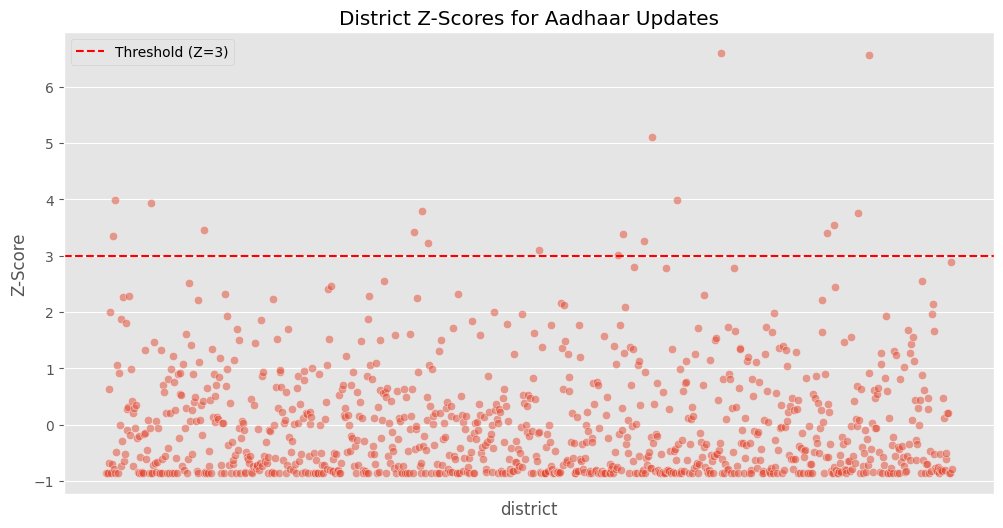

In [5]:
district_stats = df.groupby('district')['Total_Updates'].sum().reset_index()

# Calculate Z-Score
district_stats['Z_Score'] = stats.zscore(district_stats['Total_Updates'])

# Filter Outliers (Z > 3)
outliers = district_stats[district_stats['Z_Score'] > 3].sort_values(by='Z_Score', ascending=False)

print(f"Number of Statistical Outliers (Z > 3): {outliers.shape[0]}")
print("Top 10 High-Stress Districts:")
print(outliers.head(10)[['district', 'Total_Updates', 'Z_Score']])

# visualize
plt.figure(figsize=(12, 6))
sns.scatterplot(data=district_stats, x='district', y='Z_Score', alpha=0.5)
plt.axhline(3, color='red', linestyle='--', label='Threshold (Z=3)')
plt.title('District Z-Scores for Aadhaar Updates')
plt.xticks([]) # Hide x-labels for clutter
plt.ylabel('Z-Score')
plt.legend()
plt.show()